In [1]:
import sys
import os
import numpy as np
import pickle


### Add src directory

In [2]:
# current path is /Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/notebooks
# we want to add the path /Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/src

# add the path to the sys.path
# sys.path.append('/Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/src')
# or use os.path.abspath
sys.path.append(os.path.abspath("../src"))


### Import functions from src files

# Exercise 1 - Read in the data & initialize the parameters of the network

### Load Batch Function

In [9]:

def LoadBatch(batch_id, dtype=np.float64):
    """
    Load a CIFAR-10 batch file and return image data, one-hot labels, and raw labels.

    Parameters:
        filename (str): Path to the CIFAR-10 batch file.
        dtype (type): Data type for image and one-hot encoded label arrays (float32 or float64).

    Returns:
        X (numpy.ndarray): Image data of shape (3072, 10000), type float32/float64, values in [0,1].
        Y (numpy.ndarray): One-hot encoded labels of shape (10, 10000), type float32/float64.
        y (numpy.ndarray): Label vector of shape (10000,), type int (values 0-9).
    """

    cifar10_path = "/Users/axhome/AX/KTH/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment2/data/cifar-10/cifar-10-batches-py"
    # Construct full file path
    ## if batch_id is string
    if isinstance(batch_id, str):
        batch_file = os.path.join(cifar10_path, batch_id)
    else:   
        batch_file = os.path.join(cifar10_path, f"data_batch_{batch_id}")
    
    # Load the CIFAR-10 batch file
    with open(batch_file, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')

    # Extract image data and labels
    images = batch[b'data']  # Shape (10000, 3072)
    labels = np.array(batch[b'labels'])  # Shape (10000,)

    # Convert image data to float and normalize to [0,1]
    X = images.astype(dtype) / 255.0  # Shape (10000, 3072)

    # Transpose X to match required shape (3072, 10000)
    X = X.T  # Shape (3072, 10000)

    # Convert labels to one-hot encoding
    K = 10  # Number of classes in CIFAR-10
    Y = np.zeros((K, X.shape[1]), dtype=dtype)  # Shape (10, 10000)
    Y[labels, np.arange(X.shape[1])] = 1  # Assign 1s for correct labels

    # Return X (3072×10000), Y (10×10000), y (10000,)

    # make sure labels are (1x10000)
    labels = labels.reshape(1, len(labels))

    return X, Y, labels

def preprocessData(X_train_raw, X_val_raw, X_test_raw):
    """
    Normalizes the dataset based on training set mean and standard deviation.
    
    Parameters:
      X_train_raw, X_val_raw, X_test_raw: Raw data matrices
    
    Returns:
      X_train, X_val, X_test: Normalized datasets
    """
    X_train_mean = np.mean(X_train_raw, axis=1, keepdims=True)
    X_train_std = np.std(X_train_raw, axis=1, keepdims=True)

    X_train = (X_train_raw - X_train_mean) / X_train_std
    X_val = (X_val_raw - X_train_mean) / X_train_std
    X_test = (X_test_raw - X_train_mean) / X_train_std

    return X_train, X_val, X_test


def initialize_parameters(d, m, K, seed=42):
    """
    Initializes the parameters for a two-layer neural network with reproducible randomness.
    
    Args:
    - d (int): Input dimension
    - m (int): Number of hidden nodes
    - K (int): Number of output classes
    - seed (int): Random seed for reproducibility (default: 42)
    
    Returns:
    - net_params (dict): Dictionary containing initialized weights and biases
    """
    # Random number generator with a fixed seed
    rng = np.random.default_rng(seed)
    BitGen = type(rng.bit_generator)
    rng.bit_generator.state = BitGen(seed).state

    net_params = {}
    net_params['W'] = [None] * 2  # Two layers
    net_params['b'] = [None] * 2  # Two layers
    
    # Random initialization with appropriate standard deviation
    net_params['W'][0] = rng.standard_normal(size=(m, d)) / np.sqrt(d)  # First layer
    net_params['b'][0] = np.zeros((m, 1))  # First layer bias
    
    net_params['W'][1] = rng.standard_normal(size=(K, m)) / np.sqrt(m)  # Second layer
    net_params['b'][1] = np.zeros((K, 1))  # Second layer bias
    
    return net_params


### Load Data

In [10]:
X_train_raw, Y_train, y_train = LoadBatch(1)
X_val_raw, Y_val, y_val = LoadBatch(2)
X_test_raw, Y_test, y_test = LoadBatch("test_batch")

X_train, X_val, X_test = preprocessData(X_train_raw, X_val_raw, X_test_raw)

In [11]:
# Initialize the parameters of the network
d = 3072  # CIFAR-10 images are 32x32x3
m = 50    # Hidden layer size
K = 10    # Number of classes

net_params = initialize_parameters(d, m, K)

# Print shape of initialized parameters to verify
for i in range(2):
    print(f"W[{i}] shape: {net_params['W'][i].shape}, b[{i}] shape: {net_params['b'][i].shape}")


W[0] shape: (50, 3072), b[0] shape: (50, 1)
W[1] shape: (10, 50), b[1] shape: (10, 1)


## Exercise 2 - Compute the gradients for the network parameters

### Test on a mini-batch 

In [12]:
Y_train.shape

(10, 10000)

In [16]:
# Small test case
d_small = 5
n_small = 3
m_small = 6
K = 10
lam = 0

# Set up small network
rng = np.random.default_rng(42)

small_net = initialize_parameters(d_small, m_small, K)

# Generate small dataset
X_small = X_train[:d_small, :n_small]
Y_small = Y_train[:K, :n_small]
y_small = y_train[0, :n_small]


In [25]:

# Print shape of initialized parameters to verify
for i in range(2):
    print(f"W[{i}] shape: {small_net['W'][i].shape}, b[{i}] shape: {small_net['b'][i].shape}")

W[0] shape: (6, 5), b[0] shape: (6, 1)
W[1] shape: (10, 6), b[1] shape: (10, 1)


In [26]:
small_net_test = initialize_parameters(d_small, m_small, K)


In [27]:
for key in small_net_test:
    for i in range(len(small_net_test[key])):
        assert np.allclose(small_net_test[key][i], small_net[key][i]), f"{key}[{i}] in small_net_test and small_net are not the same!"

### Forward Pass Function

In [28]:
def ApplyNetwork(X, network):
    """
    Performs the forward pass through the two-layer network.
    
    Args:
    - X: (d, N) Input data, where d is the feature dimension and N is the batch size.
    - network: Dictionary containing model parameters:
        - 'W': List with W1 (m, d) and W2 (K, m)
        - 'b': List with b1 (m, 1) and b2 (K, 1)
    
    Returns:
    - fp_data: Dictionary containing intermediate and final activations:
        - 's1': Pre-activation of hidden layer
        - 'h': Activation after ReLU
        - 's': Pre-softmax scores
        - 'p': Softmax probabilities
    """
    W1, W2 = network['W']
    b1, b2 = network['b']

    # Compute first layer activations
    s1 = W1 @ X + b1  # (m, N)
    h = np.maximum(0, s1)  # ReLU activation (m, N)

    # Compute second layer activations
    s = W2 @ h + b2  # (K, N)

    # Softmax activation
    exp_s = np.exp(s - np.max(s, axis=0, keepdims=True))  # Prevent overflow
    p = exp_s / np.sum(exp_s, axis=0, keepdims=True)  # (K, N)

    # Store forward pass data for backpropagation
    fp_data = {
        's1': s1,
        'h': h,
        's': s,
        'p': p
    }

    return fp_data


### Backward Pass Function

In [29]:
def BackwardPass(X, Y, fp_data, network, lam):
    """
    Computes gradients for the two-layer network via backpropagation.

    Args:
    - X: (d, N) Input data.
    - Y: (K, N) One-hot ground truth labels.
    - fp_data: Dictionary containing forward pass values:
        - 's1': Pre-activation of hidden layer
        - 'h': Activation after ReLU
        - 's': Pre-softmax scores
        - 'p': Softmax probabilities
    - network: Dictionary containing model parameters:
        - 'W': List with W1 (m, d) and W2 (K, m)
        - 'b': List with b1 (m, 1) and b2 (K, 1)
    - lam: Regularization coefficient.

    Returns:
    - grads: Dictionary containing gradients for W1, W2, b1, and b2.
    """
    W1, W2 = network['W']
    b1, b2 = network['b']
    p, h, s1 = fp_data['p'], fp_data['h'], fp_data['s1']
    N = X.shape[1]  # Batch size

    # Compute gradient of the loss w.r.t. s (logits)
    G = p - Y  # (K, N)

    # Compute gradients for W2 and b2
    grad_W2 = (1 / N) * (G @ h.T) + 2 * lam * W2  # (K, m)
    grad_b2 = (1 / N) * np.sum(G, axis=1, keepdims=True)  # (K, 1)

    # Backpropagate through ReLU: gradient w.r.t. s1
    G_hidden = W2.T @ G  # (m, N)
    G_hidden[s1 <= 0] = 0  # Apply ReLU derivative

    # Compute gradients for W1 and b1
    grad_W1 = (1 / N) * (G_hidden @ X.T) + 2 * lam * W1  # (m, d)
    grad_b1 = (1 / N) * np.sum(G_hidden, axis=1, keepdims=True)  # (m, 1)

    # Store gradients
    grads = {
        'W': [grad_W1, grad_W2],
        'b': [grad_b1, grad_b2]
    }

    return grads


In [30]:

# Forward pass
fp_data = ApplyNetwork(X_small, small_net)



In [31]:
Y_small.shape

(10, 3)

In [32]:
X_small.shape

(5, 3)

In [33]:
d_small = 5
n_small = 3
m = 6
lam = 0

small_net['W'][0] = (1 / np.sqrt(d_small)) * rng.standard_normal(size=(m, d_small))
small_net['b'][0] = np.zeros((m, 1))
small_net['W'][1] = (1 / np.sqrt(m)) * rng.standard_normal(size=(K, m))
small_net['b'][1] = np.zeros((K, 1))

X_small = X_train[0:d_small, 0:n_small]
Y_small = Y_train[:K, 0:n_small]
Y_small.shape

(10, 3)

In [34]:

fp_data = ApplyNetwork(X_small, small_net)
my_grads = BackwardPass(X_small, Y_small, fp_data, small_net, lam=0)


In [35]:

torch_grads = ComputeGradsWithTorch(X_small, y_small[0:n_small], small_net, lam=0)

In [36]:

# Check gradient differences
for i in range(2):
    print(f"Layer {i+1} - Max abs diff in W: {np.max(np.abs(my_grads['W'][i] - torch_grads['W'][i]))}")
    print(f"Layer {i+1} - Max abs diff in b: {np.max(np.abs(my_grads['b'][i] - torch_grads['b'][i]))}")


Layer 1 - Max abs diff in W: 2.7755575615628914e-17
Layer 1 - Max abs diff in b: 1.5612511283791264e-17
Layer 2 - Max abs diff in W: 2.220446049250313e-16
Layer 2 - Max abs diff in b: 2.7755575615628914e-17


### We have now validated that the analytic gradient computations are correct
#### We can now add L2 Regularization

In [37]:

fp_data = ApplyNetwork(X_small, small_net)
my_grads = BackwardPass(X_small, Y_small, fp_data, small_net, lam=0.1)
torch_grads = ComputeGradsWithTorch(X_small, y_small[0:n_small], small_net, lam = 0.1)

# Check gradient differences
for i in range(2):
    print(f"Layer {i+1} - Max abs diff in W: {np.max(np.abs(my_grads['W'][i] - torch_grads['W'][i]))}")
    print(f"Layer {i+1} - Max abs diff in b: {np.max(np.abs(my_grads['b'][i] - torch_grads['b'][i]))}")



Layer 1 - Max abs diff in W: 2.7755575615628914e-17
Layer 1 - Max abs diff in b: 1.5612511283791264e-17
Layer 2 - Max abs diff in W: 2.220446049250313e-16
Layer 2 - Max abs diff in b: 2.7755575615628914e-17


### Sanity Check

#### Check if we can overfit the training data and get a very low loss


#### Training Function


In [42]:
def ComputeLoss(P, y, W_list, lam):
    """
    Computes the total loss function J (cross-entropy + L2 regularization).
    
    Args:
      P      : (K, N) Softmax probabilities
      y      : (N,) Ground truth class indices (integers 0 to 9)
      W_list : List of weight matrices for all layers
      lam    : Regularization coefficient
    
    Returns:
      J      : Scalar value representing the total loss
    """
    N = P.shape[1]  # Number of training examples

    # Pick correct class probabilities using indexing
    log_probs = -np.log(P[y, np.arange(N)] + 1e-15)  # Add small epsilon to prevent log(0)
    
    # Cross-entropy loss (mean over all examples)
    cross_entropy_loss = np.mean(log_probs)

    # Regularization term (sum over all weight matrices)
    reg_term = lam * sum(np.sum(W**2) for W in W_list)

    # Total cost
    J = cross_entropy_loss + reg_term
    return J

import copy

def MiniBatchGD0(X, Y, GDparams, init_net, lam):
    """
    Performs Mini-Batch Gradient Descent for training a two-layer network.

    Args:
      X        : (d, N) Input data matrix
      Y        : (K, N) One-hot encoded ground truth labels
      GDparams : Dictionary containing:
                 - "n_batch": Mini-batch size
                 - "eta": Learning rate
                 - "n_epochs": Number of epochs
      init_net : Dictionary with initial parameters:
                 - 'W': [W1, W2] weight matrices
                 - 'b': [b1, b2] bias vectors
      lam      : Regularization coefficient

    Returns:
      trained_net : Dictionary with learned parameters:
                    - 'W': [W1, W2] trained weight matrices
                    - 'b': [b1, b2] trained bias vectors
    """
    # Make a deep copy to avoid modifying the original dictionary
    trained_net = copy.deepcopy(init_net)

    # Extract hyperparameters
    n_batch = GDparams["n_batch"]
    eta = GDparams["eta"]
    n_epochs = GDparams["n_epochs"]
    
    N = X.shape[1]  # Total number of samples
    rng = np.random.default_rng(seed=42)  # Ensure reproducibility

    for epoch in range(n_epochs):
        # Shuffle the dataset
        shuffled_indices = rng.permutation(N)
        X_shuffled = X[:, shuffled_indices]
        Y_shuffled = Y[:, shuffled_indices]

        # Mini-Batch Gradient Descent
        for j in range(N // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            Xbatch = X_shuffled[:, j_start:j_end]  # Mini-batch inputs (d x n_batch)
            Ybatch = Y_shuffled[:, j_start:j_end]  # Mini-batch labels (K x n_batch)

            # Forward pass
            fp_data = ApplyNetwork(Xbatch, trained_net)
            P = fp_data['p']  # Extract softmax probabilities

            # Compute gradients
            grads = BackwardPass(Xbatch, Ybatch, fp_data, trained_net, lam)

            # Update parameters
            for i in range(2):  # Two layers
                trained_net["W"][i] -= eta * grads["W"][i]
                trained_net["b"][i] -= eta * grads["b"][i]

        # Compute and print the loss at the end of each epoch
        fp_data_train = ApplyNetwork(X, trained_net)
        P_train = fp_data_train['p']
        loss = ComputeLoss(P_train, np.argmax(Y, axis=0), trained_net["W"], lam)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f}")

    return trained_net



### Parameter Initialization

In [43]:
n_samples = 100
n_batch = 1
lam = 0
nbr_epochs = 10
eta = 0.0001

d = 3072
m = 50
K = 10


In [44]:
init_net = initialize_parameters(d, m, K)


In [45]:
overfitted_net = MiniBatchGD0(X_train[:,0:n_samples], Y_train[:,0:n_samples], {'n_batch':n_batch, 'eta':eta, 'n_epochs':nbr_epochs}, init_net, lam = 0)

Epoch 1/10 - Loss: 2.3375
Epoch 2/10 - Loss: 2.1934
Epoch 3/10 - Loss: 2.0753
Epoch 4/10 - Loss: 1.9753
Epoch 5/10 - Loss: 1.8879
Epoch 6/10 - Loss: 1.8100
Epoch 7/10 - Loss: 1.7393
Epoch 8/10 - Loss: 1.6735
Epoch 9/10 - Loss: 1.6134
Epoch 10/10 - Loss: 1.5564


In [46]:
import copy
import numpy as np
import os
import matplotlib.pyplot as plt

def MiniBatchGD(X_train, Y_train, X_val, Y_val, GDparams, init_net, lam):
    """
    Performs Mini-Batch Gradient Descent and tracks training progress.
    
    Args:
      X_train : (d, N_train) Training input data.
      Y_train : (K, N_train) One-hot encoded training labels.
      X_val   : (d, N_val) Validation input data.
      Y_val   : (K, N_val) One-hot encoded validation labels.
      GDparams: Dictionary containing:
                 - "n_batch": Mini-batch size
                 - "eta": Learning rate
                 - "n_epochs": Number of epochs
      init_net: Dictionary with initial parameters:
                 - 'W': [W1, W2] weight matrices
                 - 'b': [b1, b2] bias vectors
      lam     : Regularization coefficient.
    
    Returns:
      trained_net: Dictionary with learned parameters.
      history: Dictionary containing:
               - "cost_train", "cost_val"
               - "loss_train", "loss_val"
               - "acc_train", "acc_val"
    """
    trained_net = copy.deepcopy(init_net)  # Avoid modifying original network

    # Extract hyperparameters
    n_batch = GDparams["n_batch"]
    eta = GDparams["eta"]
    n_epochs = GDparams["n_epochs"]
    
    N_train = X_train.shape[1]  # Number of training samples
    N_val = X_val.shape[1]  # Number of validation samples
    
    rng = np.random.default_rng(seed=42)  # Reproducible shuffling
    
    # Tracking loss, cost, and accuracy
    history = {
        "cost_train": [], "cost_val": [],
        "loss_train": [], "loss_val": [],
        "acc_train": [], "acc_val": []
    }

    update_step = 0  # Track updates

    for epoch in range(n_epochs):
        shuffled_indices = rng.permutation(N_train)
        X_shuffled = X_train[:, shuffled_indices]
        Y_shuffled = Y_train[:, shuffled_indices]

        for j in range(N_train // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            Xbatch = X_shuffled[:, j_start:j_end]  # Mini-batch input (d x n_batch)
            Ybatch = Y_shuffled[:, j_start:j_end]  # Mini-batch labels (K x n_batch)

            # Forward pass
            fp_data = ApplyNetwork(Xbatch, trained_net)
            P = fp_data['p']

            # Compute gradients
            grads = BackwardPass(Xbatch, Ybatch, fp_data, trained_net, lam)

            # Update parameters
            for i in range(2):  # Two layers
                trained_net["W"][i] -= eta * grads["W"][i]
                trained_net["b"][i] -= eta * grads["b"][i]

            # Record metrics per update step
            if update_step % 10 == 0:  # Log every 10 updates
                # Compute metrics for training set
                fp_data_train = ApplyNetwork(X_train, trained_net)
                P_train = fp_data_train['p']
                loss_train = np.mean(-np.log(P_train[np.argmax(Y_train, axis=0), np.arange(N_train)] + 1e-15))
                cost_train = ComputeLoss(P_train, np.argmax(Y_train, axis=0), trained_net["W"], lam)
                acc_train = np.mean(np.argmax(P_train, axis=0) == np.argmax(Y_train, axis=0))

                # Compute metrics for validation set
                fp_data_val = ApplyNetwork(X_val, trained_net)
                P_val = fp_data_val['p']
                loss_val = np.mean(-np.log(P_val[np.argmax(Y_val, axis=0), np.arange(N_val)] + 1e-15))
                cost_val = ComputeLoss(P_val, np.argmax(Y_val, axis=0), trained_net["W"], lam)
                acc_val = np.mean(np.argmax(P_val, axis=0) == np.argmax(Y_val, axis=0))

                # Store in history
                history["cost_train"].append(cost_train)
                history["cost_val"].append(cost_val)
                history["loss_train"].append(loss_train)
                history["loss_val"].append(loss_val)
                history["acc_train"].append(acc_train)
                history["acc_val"].append(acc_val)

            update_step += 1

        # Print loss at the end of each epoch
        print(f"Epoch {epoch+1}/{n_epochs} - Cost: {cost_train:.4f} - Accuracy: {acc_train:.4f}")

    return trained_net, history


def plot_training_curves(history, image_name='default.png'):
    """
    Plots training and validation cost, loss, and accuracy over update steps.

    Args:
      history: Dictionary containing:
               - "cost_train", "cost_val"
               - "loss_train", "loss_val"
               - "acc_train", "acc_val"
    """
    save_dir = "../results/images"
    path = os.path.join(save_dir, image_name)
    
    steps = range(len(history["cost_train"]))

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Cost plot
    axes[0].plot(steps, history["cost_train"], label="Training Cost", color="blue")
    axes[0].plot(steps, history["cost_val"], label="Validation Cost", color="red")
    axes[0].set_title("Cost over Training")
    axes[0].set_xlabel("Update Steps")
    axes[0].set_ylabel("Cost")
    axes[0].legend()
    axes[0].grid()

    # Loss plot
    axes[1].plot(steps, history["loss_train"], label="Training Loss", color="blue")
    axes[1].plot(steps, history["loss_val"], label="Validation Loss", color="red")
    axes[1].set_title("Loss over Training")
    axes[1].set_xlabel("Update Steps")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid()

    # Accuracy plot
    axes[2].plot(steps, history["acc_train"], label="Training Accuracy", color="blue")
    axes[2].plot(steps, history["acc_val"], label="Validation Accuracy", color="red")
    axes[2].set_title("Accuracy over Training")
    axes[2].set_xlabel("Update Steps")
    axes[2].set_ylabel("Accuracy")
    axes[2].legend()
    axes[2].grid()

    plt.tight_layout()
    plt.savefig(path)  # Save the figure to the specified path
    plt.show()


Epoch 1/200 - Cost: 2.5121 - Accuracy: 0.0500
Epoch 2/200 - Cost: 2.4897 - Accuracy: 0.0600
Epoch 3/200 - Cost: 2.4691 - Accuracy: 0.0600
Epoch 4/200 - Cost: 2.4481 - Accuracy: 0.0600
Epoch 5/200 - Cost: 2.4286 - Accuracy: 0.0700
Epoch 6/200 - Cost: 2.4100 - Accuracy: 0.0700
Epoch 7/200 - Cost: 2.3911 - Accuracy: 0.0800
Epoch 8/200 - Cost: 2.3735 - Accuracy: 0.1000
Epoch 9/200 - Cost: 2.3563 - Accuracy: 0.1100
Epoch 10/200 - Cost: 2.3402 - Accuracy: 0.1200
Epoch 11/200 - Cost: 2.3243 - Accuracy: 0.1200
Epoch 12/200 - Cost: 2.3082 - Accuracy: 0.1300
Epoch 13/200 - Cost: 2.2932 - Accuracy: 0.1400
Epoch 14/200 - Cost: 2.2784 - Accuracy: 0.1400
Epoch 15/200 - Cost: 2.2641 - Accuracy: 0.1500
Epoch 16/200 - Cost: 2.2507 - Accuracy: 0.1500
Epoch 17/200 - Cost: 2.2371 - Accuracy: 0.1500
Epoch 18/200 - Cost: 2.2235 - Accuracy: 0.1600
Epoch 19/200 - Cost: 2.2105 - Accuracy: 0.1600
Epoch 20/200 - Cost: 2.1975 - Accuracy: 0.1800
Epoch 21/200 - Cost: 2.1850 - Accuracy: 0.1900
Epoch 22/200 - Cost: 2

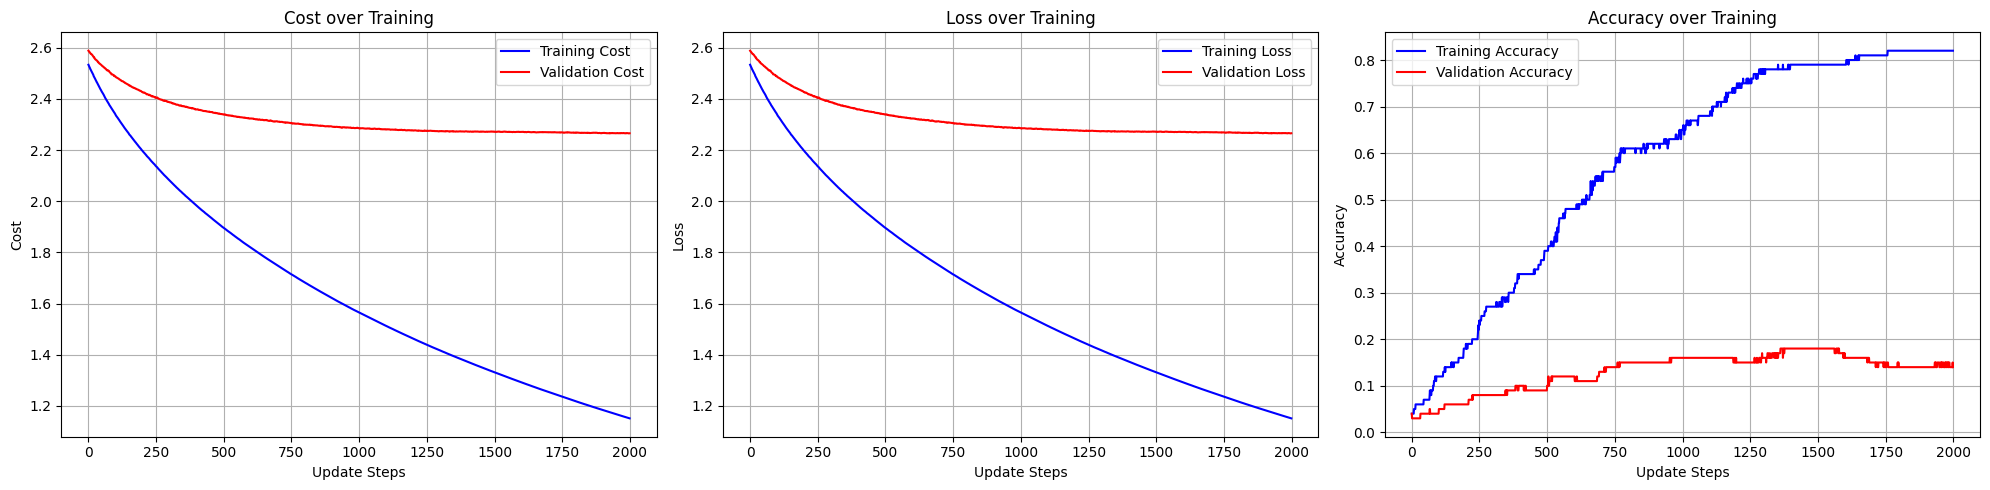

In [47]:
# Example hyperparameters
n_samples = 100
n_batch = 1
lam = 0
nbr_epochs = 200
eta = 0.00001

d = 3072
m = 50
K = 10


# Train the model
overfitted_net, history = MiniBatchGD(X_train[:,0:n_samples], Y_train[:,0:n_samples],X_val[:,0:n_samples], Y_val[:,0:n_samples], {'n_batch':n_batch, 'eta':eta, 'n_epochs':nbr_epochs}, init_net, lam = 0)
# Plot results
plot_training_curves(history, image_name='overfitted_cost_loss_acc_1.png')

In [52]:
def visualize_W_matrix(trained_net, class_names, save_path="../results/images/W_matrix.png"):
    """
    Visualizes the learnt W matrix from the first layer as class template images.

    Parameters:
        trained_net : dict
            Dictionary containing the trained network parameters.
        class_names : list
            List of class names corresponding to the CIFAR-10 dataset.
        save_path : str
            Path to save the visualized W matrix image.
    """
    plt.figure(figsize=(20, 4))  # Increase the figure size
    plt.suptitle("The learnt W matrix visualized as class template images.", fontsize=16, fontweight='bold')

    # Extract the first layer weights
    W = trained_net['W'][0]  # Shape: (m, d)
    W = W.T  # Transpose to shape (d, m)

    # Reshape the weights for visualization
    W_images = W.reshape((32, 32, 3, -1), order='F')  # Shape: (32, 32, 3, m)
    W_images = np.transpose(W_images, (1, 0, 2, 3))  # Shape: (32, 32, 3, m)

    for i in range(10):  # Visualize the first 10 classes
        w_im = W_images[:, :, :, i]
        w_im_norm = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))  # Normalize for visualization
        plt.subplot(1, 10, i + 1)
        plt.imshow(w_im_norm, interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[i], fontsize=15, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to fit the title
    plt.savefig(save_path)
    print(f"Visualization saved to {save_path}")


Visualization saved to ../results/images/W_matrix.png


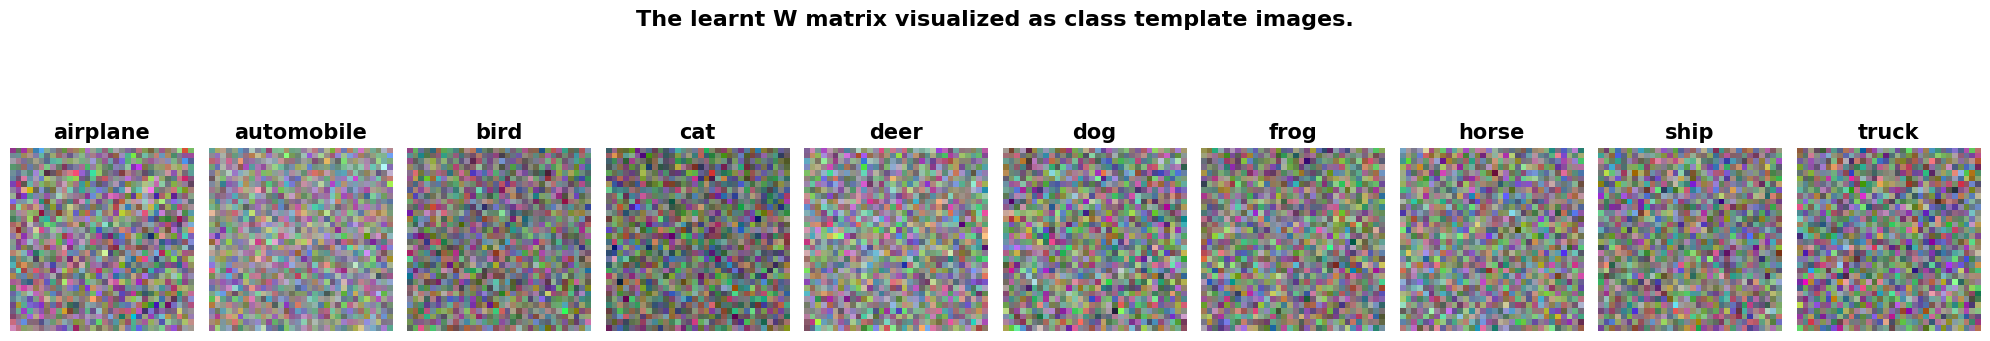

In [53]:

# Run the function
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

visualize_W_matrix(overfitted_net, class_names)


## Exercise 3 - Train network with cyclic learning rate

In [54]:
def get_cyclical_learning_rate(update_step, eta_min, eta_max, step_size):
    """
    Computes the learning rate for the current update step using cyclical learning rates.
    
    Args:
      update_step: Current update step (integer)
      eta_min: Minimum learning rate
      eta_max: Maximum learning rate
      step_size: Step size (half cycle length)
    
    Returns:
      eta: Current learning rate
    """
    # Find which cycle we're in
    cycle = update_step // (2 * step_size)
    
    # Calculate local step within the cycle
    local_step = update_step - cycle * 2 * step_size
    
    # First half of the cycle: increase eta linearly
    if local_step < step_size:
        # Equation (14) from the assignment
        eta = eta_min + (local_step / step_size) * (eta_max - eta_min)
    # Second half of the cycle: decrease eta linearly 
    else:
        # Equation (15) from the assignment
        eta = eta_max - ((local_step - step_size) / step_size) * (eta_max - eta_min)
    
    return eta


def MiniBatchGD_CLR(X_train, Y_train, X_val, Y_val, CLRparams, init_net, lam, logging_freq=10, verbose=True):
    """
    Performs Mini-Batch Gradient Descent with Cyclical Learning Rates and tracks training progress.
    
    Args:
      X_train : (d, N_train) Training input data.
      Y_train : (K, N_train) One-hot encoded training labels.
      X_val   : (d, N_val) Validation input data.
      Y_val   : (K, N_val) One-hot encoded validation labels.
      CLRparams: Dictionary containing:
                 - "n_batch": Mini-batch size
                 - "eta_min": Minimum learning rate
                 - "eta_max": Maximum learning rate
                 - "n_s": Step size (half cycle length)
                 - "n_cycles": Number of cycles to run
      init_net: Dictionary with initial parameters:
                 - 'W': [W1, W2] weight matrices
                 - 'b': [b1, b2] bias vectors
      lam     : Regularization coefficient.
      logging_freq: How often to compute and log metrics (every 'logging_freq' updates)
      verbose : Whether to print progress messages
    
    Returns:
      trained_net: Dictionary with learned parameters.
      history: Dictionary containing training metrics.
    """
    trained_net = copy.deepcopy(init_net)  # Avoid modifying original network

    # Extract hyperparameters
    n_batch = CLRparams["n_batch"]
    eta_min = CLRparams["eta_min"]
    eta_max = CLRparams["eta_max"]
    step_size = CLRparams["n_s"]
    n_cycles = CLRparams["n_cycles"]
    
    # Calculate total number of update steps to run
    n_updates_per_cycle = 2 * step_size
    total_updates = n_cycles * n_updates_per_cycle
    
    N_train = X_train.shape[1]  # Number of training samples
    N_val = X_val.shape[1]  # Number of validation samples
    
    rng = np.random.default_rng(seed=42)  # Reproducible shuffling
    
    # Tracking loss, cost, and accuracy
    history = {
        "cost_train": [], "cost_val": [],
        "loss_train": [], "loss_val": [],
        "acc_train": [], "acc_val": [],
        "update_steps": [],
        "learning_rates": []
    }

    update_step = 0  # Track updates
    
    # Continue training until we've completed the specified number of updates
    while update_step < total_updates:
        # Shuffle training data for this epoch
        shuffled_indices = rng.permutation(N_train)
        X_shuffled = X_train[:, shuffled_indices]
        Y_shuffled = Y_train[:, shuffled_indices]

        # Process mini-batches for this epoch
        for j in range(N_train // n_batch):
            # Skip once we've done enough updates
            if update_step >= total_updates:
                break
                
            # Get current learning rate based on update step
            eta = get_cyclical_learning_rate(update_step, eta_min, eta_max, step_size)
            
            # Extract mini-batch
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            Xbatch = X_shuffled[:, j_start:j_end]
            Ybatch = Y_shuffled[:, j_start:j_end]

            # Forward pass
            fp_data = ApplyNetwork(Xbatch, trained_net)
            
            # Compute gradients
            grads = BackwardPass(Xbatch, Ybatch, fp_data, trained_net, lam)

            # Update parameters with current learning rate
            for i in range(2):  # Two layers
                trained_net["W"][i] -= eta * grads["W"][i]
                trained_net["b"][i] -= eta * grads["b"][i]

            # Record metrics periodically
            if update_step % logging_freq == 0:
                # Compute metrics for training set
                fp_data_train = ApplyNetwork(X_train, trained_net)
                P_train = fp_data_train['p']
                y_train_indices = np.argmax(Y_train, axis=0)
                loss_train = ComputeLoss(P_train, y_train_indices, trained_net["W"], 0)  # Loss without regularization
                cost_train = ComputeLoss(P_train, y_train_indices, trained_net["W"], lam)  # Cost with regularization
                acc_train = np.mean(np.argmax(P_train, axis=0) == y_train_indices)

                # Compute metrics for validation set
                fp_data_val = ApplyNetwork(X_val, trained_net)
                P_val = fp_data_val['p']
                y_val_indices = np.argmax(Y_val, axis=0)
                loss_val = ComputeLoss(P_val, y_val_indices, trained_net["W"], 0)  # Loss without regularization
                cost_val = ComputeLoss(P_val, y_val_indices, trained_net["W"], lam)  # Cost with regularization
                acc_val = np.mean(np.argmax(P_val, axis=0) == y_val_indices)

                # Store in history
                history["cost_train"].append(cost_train)
                history["cost_val"].append(cost_val)
                history["loss_train"].append(loss_train)
                history["loss_val"].append(loss_val)
                history["acc_train"].append(acc_train)
                history["acc_val"].append(acc_val)
                history["update_steps"].append(update_step)
                history["learning_rates"].append(eta)
                
                if verbose and update_step % (logging_freq * 10) == 0:
                    cycle_progress = update_step / n_updates_per_cycle
                    total_progress = update_step / total_updates
                    print(f"Update step {update_step}/{total_updates} - Cycle {int(cycle_progress)}.{int(10*(cycle_progress-int(cycle_progress)))} - "
                          f"Eta: {eta:.6f} - Cost: {cost_train:.4f} - Accuracy: {acc_train:.4f}")

            update_step += 1

    return trained_net, history


def ComputeLoss(P, y, W, lam):
    """
    Computes the cost function value (cross-entropy loss + regularization).
    
    Args:
      P: Probability outputs from the network (K, N)
      y: Ground truth labels as indices (N,)
      W: List of weight matrices [W1, W2]
      lam: Regularization coefficient
    
    Returns:
      loss: Cross-entropy loss value
      cost: Cross-entropy loss + regularization
    """
    # Number of samples
    N = P.shape[1]
    
    # Cross-entropy loss: -1/N * sum(log(p_y))
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    ce_loss = -np.mean(np.log(P[y, np.arange(N)] + epsilon))
    
    # Regularization term: lambda * sum(W_ij^2)
    reg_term = 0
    if lam > 0:
        for w in W:
            reg_term += lam * np.sum(w**2)
            
    # Total cost
    cost = ce_loss + reg_term
    
    return cost


def plot_training_curves_clr(history, image_name='clr_training_curves.png'):
    """
    Plots training and validation cost, loss, and accuracy over update steps
    with cyclical learning rates.
    
    Args:
      history: Dictionary containing training metrics
      image_name: Filename for saving the plot
    """
    save_dir = "."  # Change to your desired directory
    path = os.path.join(save_dir, image_name)
    
    # Create a figure with 4 subplots (including learning rate plot)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    steps = history["update_steps"]
    
    # Cost plot
    axes[0, 0].plot(steps, history["cost_train"], label="Training", color="blue")
    axes[0, 0].plot(steps, history["cost_val"], label="Validation", color="red")
    axes[0, 0].set_title("Cost plot")
    axes[0, 0].set_xlabel("Update step")
    axes[0, 0].set_ylabel("Cost")
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss plot
    axes[0, 1].plot(steps, history["loss_train"], label="Training", color="blue")
    axes[0, 1].plot(steps, history["loss_val"], label="Validation", color="red")
    axes[0, 1].set_title("Loss plot")
    axes[0, 1].set_xlabel("Update step")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Accuracy plot
    axes[1, 0].plot(steps, history["acc_train"], label="Training", color="blue")
    axes[1, 0].plot(steps, history["acc_val"], label="Validation", color="red")
    axes[1, 0].set_title("Accuracy plot")
    axes[1, 0].set_xlabel("Update step")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning rate plot
    axes[1, 1].plot(steps, history["learning_rates"], color="green")
    axes[1, 1].set_title("Learning Rate")
    axes[1, 1].set_xlabel("Update step")
    axes[1, 1].set_ylabel("Learning Rate")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

Loading and preprocessing datasets...
Initializing network parameters...
Training network with cyclical learning rates for 1 cycle(s)...
Parameters: eta_min=1e-05, eta_max=0.1, step_size=500
Update step 0/1000 - Cycle 0.0 - Eta: 0.000010 - Cost: 3.0712 - Accuracy: 0.0975
Update step 100/1000 - Cycle 0.1 - Eta: 0.020008 - Cost: 2.4149 - Accuracy: 0.3651
Update step 200/1000 - Cycle 0.2 - Eta: 0.040006 - Cost: 2.1689 - Accuracy: 0.4268
Update step 300/1000 - Cycle 0.3 - Eta: 0.060004 - Cost: 2.0119 - Accuracy: 0.4574
Update step 400/1000 - Cycle 0.4 - Eta: 0.080002 - Cost: 1.8860 - Accuracy: 0.4707
Update step 500/1000 - Cycle 0.5 - Eta: 0.100000 - Cost: 1.8577 - Accuracy: 0.4483
Update step 600/1000 - Cycle 0.6 - Eta: 0.080002 - Cost: 1.6825 - Accuracy: 0.5069
Update step 700/1000 - Cycle 0.7 - Eta: 0.060004 - Cost: 1.5633 - Accuracy: 0.5543
Update step 800/1000 - Cycle 0.8 - Eta: 0.040006 - Cost: 1.5097 - Accuracy: 0.5750
Update step 900/1000 - Cycle 0.9 - Eta: 0.020008 - Cost: 1.4647 

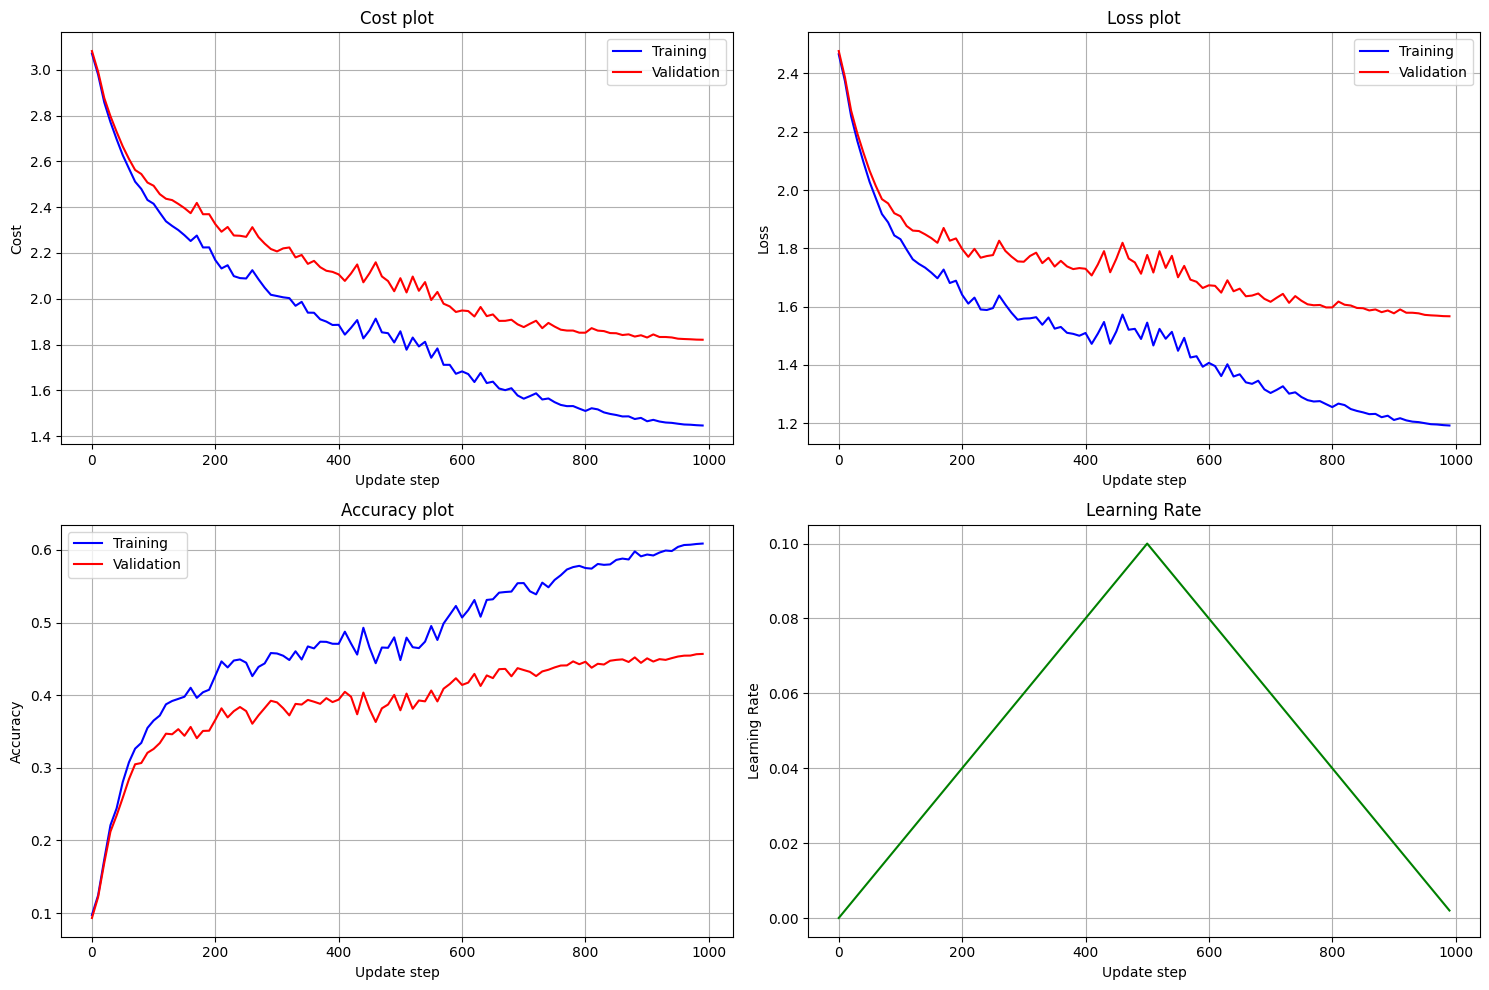

Evaluating on the test set...
Test accuracy: 0.4575

Running Exercise 4: Training with 3 cycles and n_s=800...
Update step 0/4800 - Cycle 0.0 - Eta: 0.000010 - Cost: 3.0712 - Accuracy: 0.0975
Update step 300/4800 - Cycle 0.1 - Eta: 0.037506 - Cost: 2.0858 - Accuracy: 0.4550
Update step 600/4800 - Cycle 0.3 - Eta: 0.075002 - Cost: 1.7906 - Accuracy: 0.4868
Update step 900/4800 - Cycle 0.5 - Eta: 0.087501 - Cost: 1.6075 - Accuracy: 0.5225
Update step 1200/4800 - Cycle 0.7 - Eta: 0.050005 - Cost: 1.4468 - Accuracy: 0.5992
Update step 1500/4800 - Cycle 0.9 - Eta: 0.012509 - Cost: 1.3587 - Accuracy: 0.6433
Update step 1800/4800 - Cycle 1.1 - Eta: 0.025008 - Cost: 1.3594 - Accuracy: 0.6434
Update step 2100/4800 - Cycle 1.3 - Eta: 0.062504 - Cost: 1.4562 - Accuracy: 0.6050
Update step 2400/4800 - Cycle 1.5 - Eta: 0.100000 - Cost: 1.5612 - Accuracy: 0.5442
Update step 2700/4800 - Cycle 1.6 - Eta: 0.062504 - Cost: 1.4304 - Accuracy: 0.6051
Update step 3000/4800 - Cycle 1.8 - Eta: 0.025008 - Cos

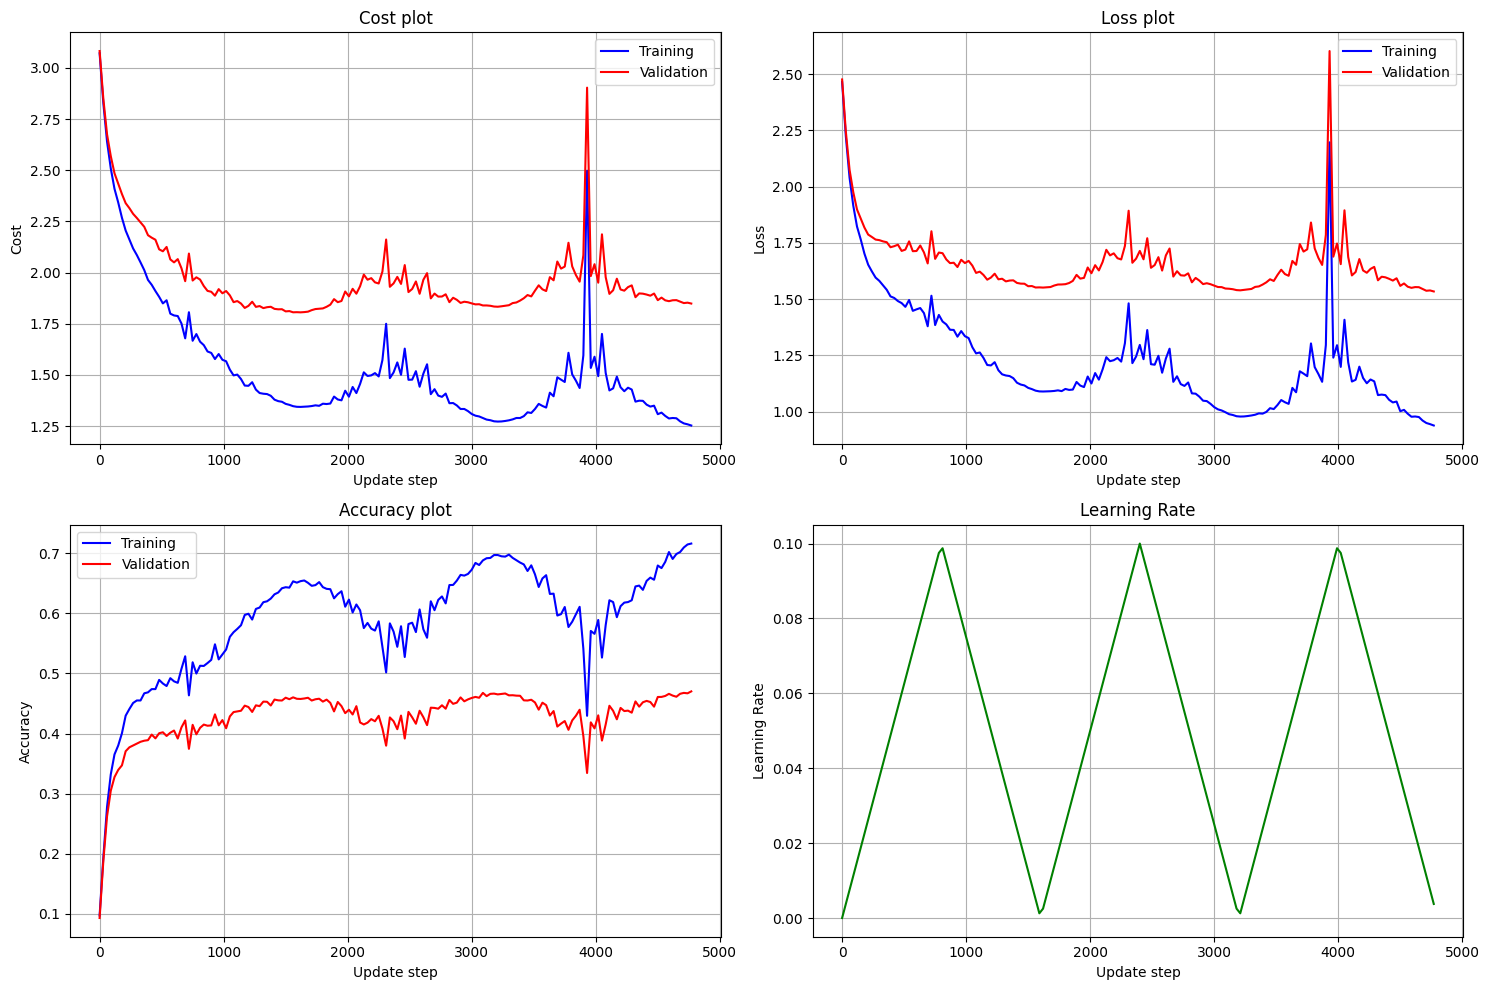

Test accuracy after 3 cycles: 0.4706


In [55]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and preprocess data as specified in the assignment
# Load 1 batch for training and 1 for validation for this exercise
print("Loading and preprocessing datasets...")
X_train_raw, Y_train, y_train = LoadBatch(1)  # data_batch_1 for training
X_val_raw, Y_val, y_val = LoadBatch(2)        # data_batch_2 for validation
X_test_raw, Y_test, y_test = LoadBatch("test_batch")  # test_batch for testing

# Preprocess the data
X_train, X_val, X_test = preprocessData(X_train_raw, X_val_raw, X_test_raw)

# 2. Initialize network parameters
print("Initializing network parameters...")
d = X_train.shape[0]  # Input dimension (3072 for CIFAR-10)
m = 50               # Hidden layer size
K = 10               # Number of classes
init_net = initialize_parameters(d, m, K, seed=42)

# 3. Set up cyclical learning rate parameters as specified in the assignment
# According to the assignment, initially use:
#   - eta_min = 1e-5
#   - eta_max = 1e-1
#   - n_s = 500 (step size)
#   - batch size = 100
lam = 0.01  # Default regularization parameter from the assignment

clr_params = {
    "n_batch": 100,
    "eta_min": 1e-5,
    "eta_max": 1e-1,
    "n_s": 500,
    "n_cycles": 1  # For one cycle of training as mentioned in the assignment
}

# 4. Train the network with cyclical learning rates
print(f"Training network with cyclical learning rates for {clr_params['n_cycles']} cycle(s)...")
print(f"Parameters: eta_min={clr_params['eta_min']}, eta_max={clr_params['eta_max']}, step_size={clr_params['n_s']}")

# Train for one cycle (as per Exercise 3)
trained_net, history = MiniBatchGD_CLR(
    X_train, Y_train, X_val, Y_val, 
    clr_params, init_net, lam,
    logging_freq=10, verbose=True
)

# 5. Plot the results
print("Plotting training curves...")
plot_training_curves_clr(history, image_name='cyclical_learning_one_cycle.png')

# 6. Evaluate on the test set
print("Evaluating on the test set...")
fp_data_test = ApplyNetwork(X_test, trained_net)
P_test = fp_data_test['p']
acc_test = np.mean(np.argmax(P_test, axis=0) == np.argmax(Y_test, axis=0))
print(f"Test accuracy: {acc_test:.4f}")

# Now let's run for 3 cycles with n_s=800 as specified in Exercise 4
print("\nRunning Exercise 4: Training with 3 cycles and n_s=800...")
clr_params_ex4 = {
    "n_batch": 100,
    "eta_min": 1e-5,
    "eta_max": 1e-1,
    "n_s": 800,
    "n_cycles": 3
}

trained_net_ex4, history_ex4 = MiniBatchGD_CLR(
    X_train, Y_train, X_val, Y_val,
    clr_params_ex4, init_net, lam,
    logging_freq=30, verbose=True
)

# Plot the results for Exercise 4
plot_training_curves_clr(history_ex4, image_name='cyclical_learning_three_cycles.png')

# Evaluate on the test set
fp_data_test = ApplyNetwork(X_test, trained_net_ex4)
P_test = fp_data_test['p']
acc_test = np.mean(np.argmax(P_test, axis=0) == np.argmax(Y_test, axis=0))
print(f"Test accuracy after 3 cycles: {acc_test:.4f}")

## Exercise 4 - Train network For Real 

In [56]:
def lambda_coarse_search(X_train, Y_train, X_val, Y_val, clr_params, l_min, l_max, n_values, search_type='grid'):
    """
    Performs a coarse search for optimal regularization parameter lambda.
    
    Args:
      X_train, Y_train: Training data and labels
      X_val, Y_val: Validation data and labels
      clr_params: Parameters for cyclical learning rate
      l_min, l_max: Minimum and maximum lambda values (in log10 scale)
      n_values: Number of lambda values to try
      search_type: 'grid' for uniform grid or 'random' for random sampling
    
    Returns:
      results: Dictionary with lambda values and corresponding validation accuracies
    """
    d = X_train.shape[0]
    K = Y_train.shape[0]
    m = 50  # Number of hidden nodes
    
    # Setup lambda values (in log scale)
    if search_type == 'grid':
        # Create a uniform grid of lambda values
        l_values = np.logspace(l_min, l_max, n_values)
    else:
        # Sample random values in the log space
        l_values = np.power(10, l_min + (l_max - l_min) * np.random.random(n_values))
    
    # Store results
    results = {
        'lambda_values': l_values,
        'val_accuracies': np.zeros(n_values),
        'train_accuracies': np.zeros(n_values),
        'best_networks': []
    }
    
    # Test each lambda value
    for i, lam in enumerate(l_values):
        print(f"Training with lambda = {lam:.6f} ({i+1}/{n_values})")
        
        # Initialize a new network for each lambda
        init_net = initialize_parameters(d, m, K, seed=42+i)  # Different seed for each run
        
        # Train for 2 cycles as recommended in the assignment
        clr_params_search = clr_params.copy()
        clr_params_search['n_cycles'] = 2
        
        # Set step size according to the assignment recommendation
        N = X_train.shape[1]
        n_batch = clr_params['n_batch']
        clr_params_search['n_s'] = 2 * int(np.floor(N / n_batch))
        
        # Train network
        trained_net, history = MiniBatchGD_CLR(
            X_train, Y_train, X_val, Y_val, 
            clr_params_search, init_net, lam,
            logging_freq=50, verbose=False
        )
        
        # Evaluate on validation set
        fp_data_val = ApplyNetwork(X_val, trained_net)
        P_val = fp_data_val['p']
        val_acc = np.mean(np.argmax(P_val, axis=0) == np.argmax(Y_val, axis=0))
        
        # Evaluate on training set
        fp_data_train = ApplyNetwork(X_train, trained_net)
        P_train = fp_data_train['p']
        train_acc = np.mean(np.argmax(P_train, axis=0) == np.argmax(Y_train, axis=0))
        
        # Store results
        results['val_accuracies'][i] = val_acc
        results['train_accuracies'][i] = train_acc
        results['best_networks'].append(trained_net)
        
        print(f"  Validation accuracy: {val_acc:.4f}, Training accuracy: {train_acc:.4f}")
    
    return results


def lambda_fine_search(X_train, Y_train, X_val, Y_val, clr_params, best_lambda_range, n_values):
    """
    Performs a fine search for optimal regularization parameter lambda
    around the best values found in the coarse search.
    
    Args:
      X_train, Y_train: Training data and labels
      X_val, Y_val: Validation data and labels
      clr_params: Parameters for cyclical learning rate
      best_lambda_range: (min_lambda, max_lambda) range for fine search
      n_values: Number of lambda values to try
    
    Returns:
      results: Dictionary with lambda values and corresponding validation accuracies
    """
    l_min = np.log10(best_lambda_range[0])
    l_max = np.log10(best_lambda_range[1])
    
    # Use random sampling for fine search
    return lambda_coarse_search(
        X_train, Y_train, X_val, Y_val, 
        clr_params, l_min, l_max, n_values, 
        search_type='random'
    )


def plot_lambda_search_results(results, title="Lambda Search Results", filename="lambda_search.png"):
    """
    Plots the results of the lambda search.
    
    Args:
      results: Dictionary with lambda values and validation accuracies
      title: Plot title
      filename: File to save the plot
    """
    plt.figure(figsize=(10, 6))
    
    # Sort the results by lambda value for better visualization
    sorted_indices = np.argsort(results['lambda_values'])
    lambda_values = np.array(results['lambda_values'])[sorted_indices]
    val_accs = np.array(results['val_accuracies'])[sorted_indices]
    train_accs = np.array(results['train_accuracies'])[sorted_indices]
    
    # Plot accuracies vs lambda
    plt.semilogx(lambda_values, val_accs, 'o-', label='Validation Accuracy')
    plt.semilogx(lambda_values, train_accs, 's-', label='Training Accuracy')
    
    # Find and mark the best lambda
    best_idx = np.argmax(val_accs)
    best_lambda = lambda_values[best_idx]
    best_val_acc = val_accs[best_idx]
    
    plt.axvline(x=best_lambda, color='r', linestyle='--', alpha=0.5)
    plt.plot(best_lambda, best_val_acc, 'r*', markersize=15)
    
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Accuracy')
    plt.title(f"{title}\nBest lambda: {best_lambda:.6f}, Accuracy: {best_val_acc:.4f}")
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    
    return best_lambda, best_val_acc


def train_final_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, best_lambda, clr_params):
    """
    Trains the final model with the best lambda found.
    
    Args:
      X_train, Y_train: Training data and labels
      X_val, Y_val: Validation data and labels
      X_test, Y_test: Test data and labels
      best_lambda: Best lambda value from search
      clr_params: Parameters for cyclical learning rate
    
    Returns:
      trained_net: The final trained network
      history: Training history
      test_acc: Test accuracy
    """
    d = X_train.shape[0]
    K = Y_train.shape[0]
    m = 50  # Hidden layer size
    
    # Initialize network
    init_net = initialize_parameters(d, m, K, seed=42)
    
    # Set parameters for final training
    final_params = clr_params.copy()
    final_params['n_cycles'] = 3
    final_params['n_s'] = 800
    
    print(f"Training final model with lambda = {best_lambda:.6f}")
    
    # Train network
    trained_net, history = MiniBatchGD_CLR(
        X_train, Y_train, X_val, Y_val,
        final_params, init_net, best_lambda,
        logging_freq=30, verbose=True
    )
    
    # Evaluate on test set
    fp_data_test = ApplyNetwork(X_test, trained_net)
    P_test = fp_data_test['p']
    test_acc = np.mean(np.argmax(P_test, axis=0) == np.argmax(Y_test, axis=0))
    
    print(f"Final test accuracy: {test_acc:.4f}")
    
    return trained_net, history, test_acc

Starting Exercise 4 - Searching for optimal lambda and final training
Loading and preprocessing datasets...
Dataset prepared: 45000 training samples, 5000 validation samples, 10000 test samples

Starting coarse search for lambda...
Training with lambda = 0.000010 (1/8)
  Validation accuracy: 0.5224, Training accuracy: 0.5887
Training with lambda = 0.000037 (2/8)
  Validation accuracy: 0.5212, Training accuracy: 0.5898
Training with lambda = 0.000139 (3/8)
  Validation accuracy: 0.5252, Training accuracy: 0.5912
Training with lambda = 0.000518 (4/8)
  Validation accuracy: 0.5190, Training accuracy: 0.5875
Training with lambda = 0.001931 (5/8)
  Validation accuracy: 0.5202, Training accuracy: 0.5813
Training with lambda = 0.007197 (6/8)
  Validation accuracy: 0.5168, Training accuracy: 0.5494
Training with lambda = 0.026827 (7/8)
  Validation accuracy: 0.4708, Training accuracy: 0.4869
Training with lambda = 0.100000 (8/8)
  Validation accuracy: 0.3846, Training accuracy: 0.3898


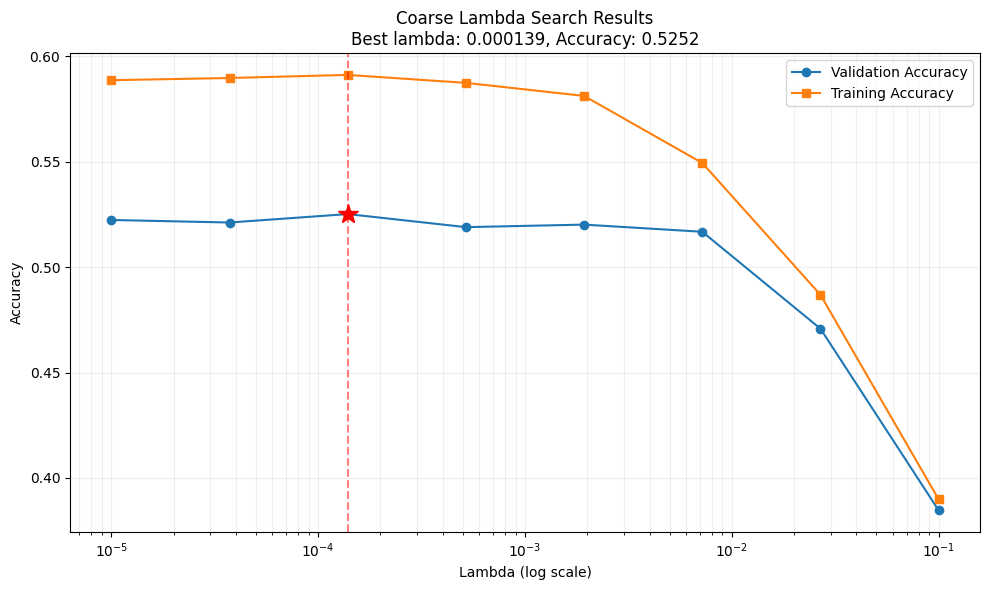


Starting fine search for lambda...
Training with lambda = 0.000007 (1/8)
  Validation accuracy: 0.5238, Training accuracy: 0.5887
Training with lambda = 0.000030 (2/8)
  Validation accuracy: 0.5228, Training accuracy: 0.5905
Training with lambda = 0.000019 (3/8)
  Validation accuracy: 0.5216, Training accuracy: 0.5917
Training with lambda = 0.000004 (4/8)
  Validation accuracy: 0.5148, Training accuracy: 0.5919
Training with lambda = 0.000097 (5/8)
  Validation accuracy: 0.5148, Training accuracy: 0.5918
Training with lambda = 0.000125 (6/8)
  Validation accuracy: 0.5246, Training accuracy: 0.5877
Training with lambda = 0.000008 (7/8)
  Validation accuracy: 0.5224, Training accuracy: 0.5920
Training with lambda = 0.000004 (8/8)
  Validation accuracy: 0.5262, Training accuracy: 0.5897


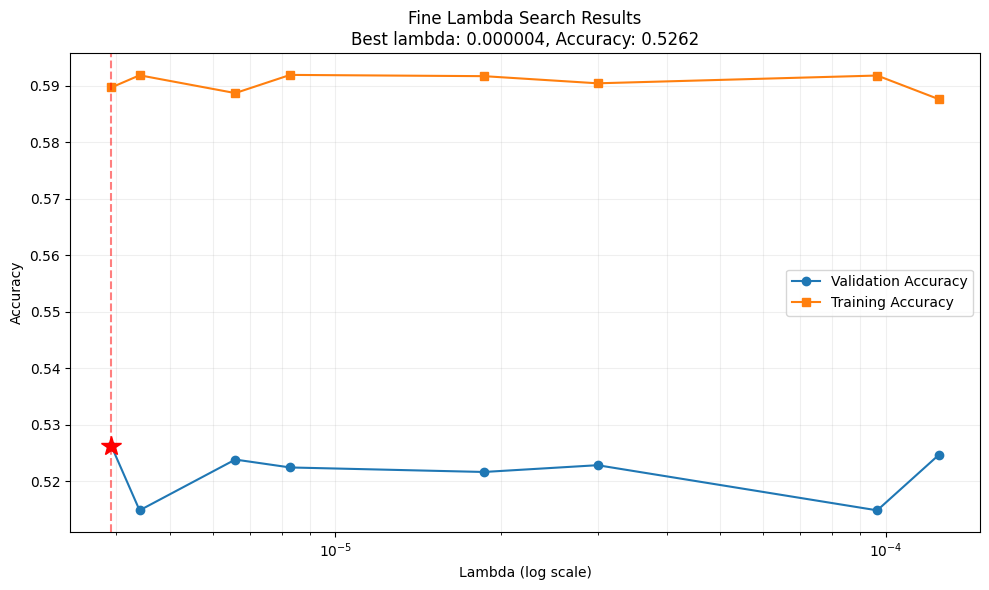


Training final model with best lambda...
Training final model with lambda = 0.000004
Update step 0/4800 - Cycle 0.0 - Eta: 0.000010 - Cost: 2.4710 - Accuracy: 0.0952
Update step 300/4800 - Cycle 0.1 - Eta: 0.037506 - Cost: 1.6833 - Accuracy: 0.4140
Update step 600/4800 - Cycle 0.3 - Eta: 0.075002 - Cost: 1.6428 - Accuracy: 0.4319
Update step 900/4800 - Cycle 0.5 - Eta: 0.087501 - Cost: 1.5028 - Accuracy: 0.4698
Update step 1200/4800 - Cycle 0.7 - Eta: 0.050005 - Cost: 1.4138 - Accuracy: 0.5032
Update step 1500/4800 - Cycle 0.9 - Eta: 0.012509 - Cost: 1.3284 - Accuracy: 0.5386
Update step 1800/4800 - Cycle 1.1 - Eta: 0.025008 - Cost: 1.3292 - Accuracy: 0.5342
Update step 2100/4800 - Cycle 1.3 - Eta: 0.062504 - Cost: 1.3947 - Accuracy: 0.5079
Update step 2400/4800 - Cycle 1.5 - Eta: 0.100000 - Cost: 1.4344 - Accuracy: 0.4943
Update step 2700/4800 - Cycle 1.6 - Eta: 0.062504 - Cost: 1.3446 - Accuracy: 0.5267
Update step 3000/4800 - Cycle 1.8 - Eta: 0.025008 - Cost: 1.2533 - Accuracy: 0.5

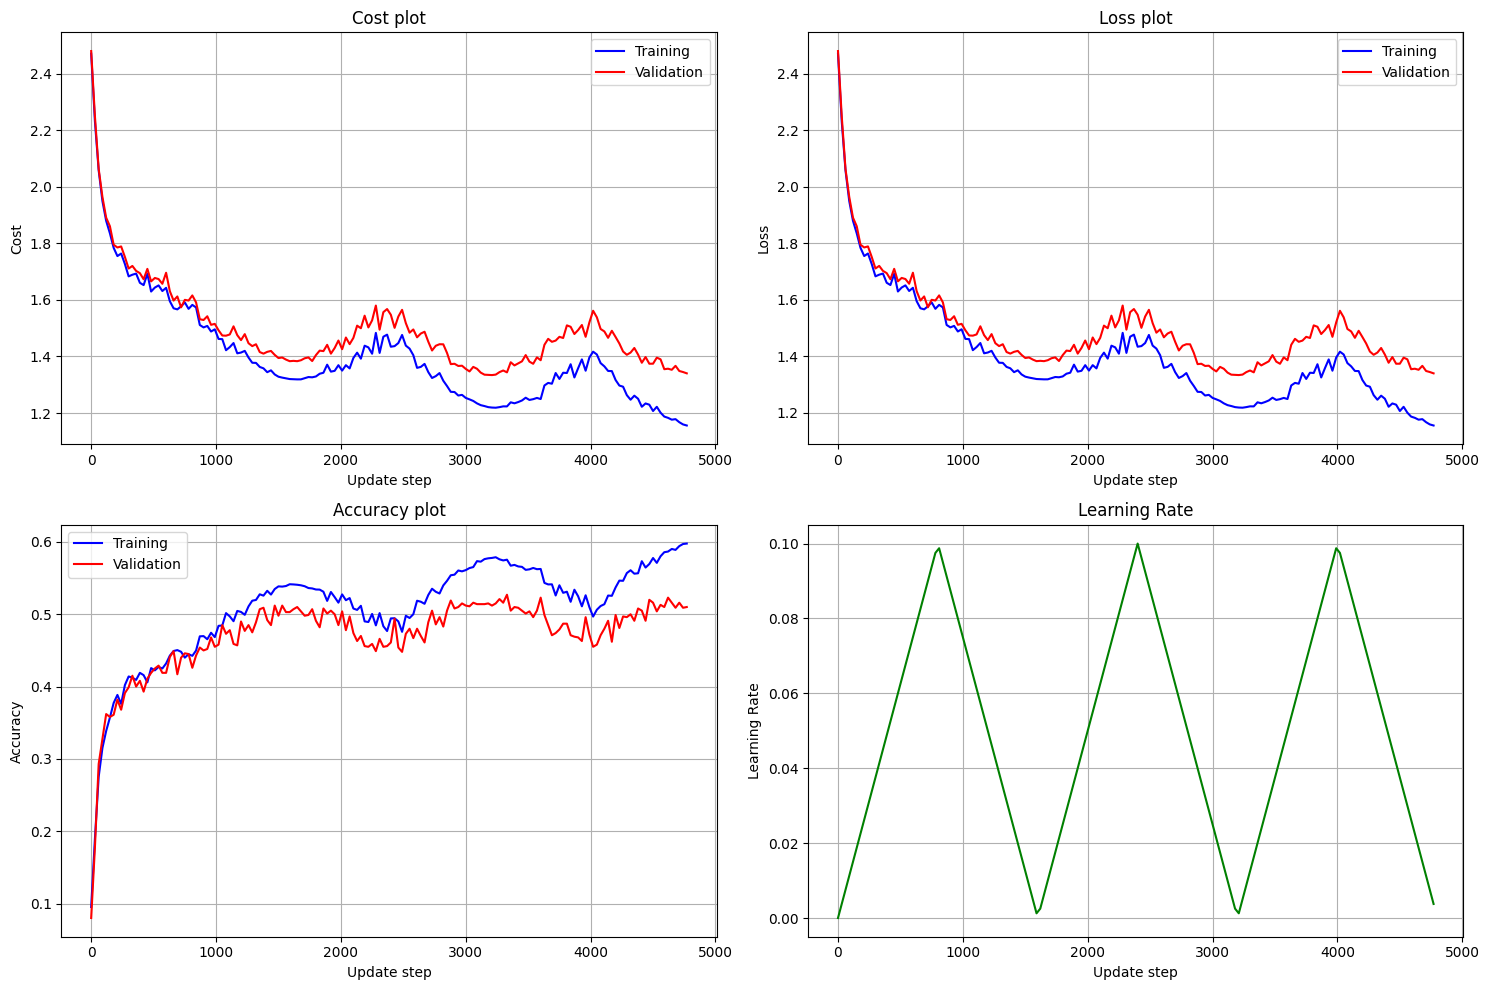


Exercise 4 completed in 5225.77 seconds (87.10 minutes)
Final test accuracy: 0.5114
Model saved to: ../results/weights/final_model_20250416_121623.npz
Training history saved to: ../results/logs/training_history_20250416_121623.npz
Check the logs directory for detailed results


In [58]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

def run_exercise4():
    """
    Runs Exercise 4 of the assignment:
    1. Load and preprocess all training data
    2. Perform coarse search for lambda
    3. Perform fine search based on coarse search results
    4. Train final model with best lambda value
    5. Evaluate on test set
    """
    print("Starting Exercise 4 - Searching for optimal lambda and final training")
    start_time = time.time()
    
    # Setup directories for saving results
    base_dir = '../results'
    images_dir = os.path.join(base_dir, 'images')
    logs_dir = os.path.join(base_dir, 'logs')
    plots_dir = os.path.join(base_dir, 'plots')
    weights_dir = os.path.join(base_dir, 'weights')
    
    # Create timestamp for file naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Ensure directories exist
    for directory in [images_dir, logs_dir, plots_dir, weights_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # 1. Load and preprocess all training data as specified in the assignment
    # For the lambda search, use all 5 training batches with 5000 validation samples
    print("Loading and preprocessing datasets...")
    
    # Load all batches
    X_all = []
    Y_all = []
    y_all = []
    
    for batch_id in range(1, 6):
        X_batch, Y_batch, y_batch = LoadBatch(batch_id)
        X_all.append(X_batch)
        Y_all.append(Y_batch)
        y_all.append(y_batch)
    
    # Concatenate all batches
    X_all_raw = np.concatenate(X_all, axis=1)
    Y_all = np.concatenate(Y_all, axis=1)
    y_all = np.concatenate(y_all, axis=1)
    
    # Split into training and validation sets
    val_size = 5000
    X_train_raw = X_all_raw[:, :-val_size]
    Y_train = Y_all[:, :-val_size]
    y_train = y_all[:, :-val_size]
    
    X_val_raw = X_all_raw[:, -val_size:]
    Y_val = Y_all[:, -val_size:]
    y_val = y_all[:, -val_size:]
    
    # Load test data
    X_test_raw, Y_test, y_test = LoadBatch("test_batch")
    
    # Preprocess the data
    X_train_mean = np.mean(X_train_raw, axis=1, keepdims=True)
    X_train_std = np.std(X_train_raw, axis=1, keepdims=True)
    
    X_train = (X_train_raw - X_train_mean) / X_train_std
    X_val = (X_val_raw - X_train_mean) / X_train_std
    X_test = (X_test_raw - X_train_mean) / X_train_std
    
    # Extract dimensions
    d = X_train.shape[0]
    K = Y_train.shape[0]
    N_train = X_train.shape[1]
    
    print(f"Dataset prepared: {N_train} training samples, {X_val.shape[1]} validation samples, {X_test.shape[1]} test samples")
    
    # Log the data preprocessing information
    with open(os.path.join(logs_dir, f"data_preprocessing_{timestamp}.txt"), 'w') as log_file:
        log_file.write(f"Dataset prepared at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        log_file.write(f"Training samples: {N_train}\n")
        log_file.write(f"Validation samples: {X_val.shape[1]}\n")
        log_file.write(f"Test samples: {X_test.shape[1]}\n")
        log_file.write(f"Feature dimension: {d}\n")
        log_file.write(f"Number of classes: {K}\n")
        log_file.write(f"Training data mean shape: {X_train_mean.shape}\n")
        log_file.write(f"Training data std shape: {X_train_std.shape}\n")

    # Set up CLR parameters for lambda search
    batch_size = 100
    clr_params = {
        "n_batch": batch_size,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_s": 2 * int(np.floor(N_train / batch_size)),  # As per assignment recommendation
        "n_cycles": 2  # 2 cycles recommended for lambda search
    }
    
    # 2. Perform coarse search for lambda on a log scale
    print("\nStarting coarse search for lambda...")
    l_min = -5  # 10^-5
    l_max = -1  # 10^-1
    n_values = 8  # 8 different values in the grid
    
    coarse_results = lambda_coarse_search(
        X_train, Y_train, X_val, Y_val,
        clr_params, l_min, l_max, n_values,
        search_type='grid'
    )
    
    # Plot and save coarse search results
    best_lambda_coarse, best_acc_coarse = plot_lambda_search_results(
        coarse_results, 
        title="Coarse Lambda Search Results",
        filename=os.path.join(plots_dir, f"lambda_coarse_search_{timestamp}.png")
    )
    
    # 3. Perform fine search around the best values from coarse search
    print("\nStarting fine search for lambda...")
    
    # Identify range for fine search based on top 3 lambdas
    sorted_indices = np.argsort(-coarse_results['val_accuracies'])
    top_3_lambdas = [coarse_results['lambda_values'][i] for i in sorted_indices[:3]]
    min_lambda = min(top_3_lambdas) / 3
    max_lambda = max(top_3_lambdas) * 3
    
    fine_results = lambda_fine_search(
        X_train, Y_train, X_val, Y_val,
        clr_params, (min_lambda, max_lambda), 
        n_values=8
    )
    
    # Plot and save fine search results
    best_lambda_fine, best_acc_fine = plot_lambda_search_results(
        fine_results, 
        title="Fine Lambda Search Results",
        filename=os.path.join(plots_dir, f"lambda_fine_search_{timestamp}.png")
    )
    
    # Save the lambda search results
    lambda_search_results = {
        'coarse_search': {
            'lambda_values': coarse_results['lambda_values'],
            'val_accuracies': coarse_results['val_accuracies'],
            'train_accuracies': coarse_results['train_accuracies'],
            'best_lambda': best_lambda_coarse,
            'best_accuracy': best_acc_coarse
        },
        'fine_search': {
            'lambda_values': fine_results['lambda_values'],
            'val_accuracies': fine_results['val_accuracies'],
            'train_accuracies': fine_results['train_accuracies'],
            'best_lambda': best_lambda_fine,
            'best_accuracy': best_acc_fine
        }
    }
    
    np.savez(
        os.path.join(logs_dir, f"lambda_search_results_{timestamp}.npz"),
        **lambda_search_results
    )
    
    # Log the lambda search information
    with open(os.path.join(logs_dir, f"lambda_search_{timestamp}.txt"), 'w') as log_file:
        log_file.write(f"Lambda search completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        log_file.write("Coarse search parameters:\n")
        log_file.write(f"  Log range: [{l_min}, {l_max}]\n")
        log_file.write(f"  Number of values: {n_values}\n")
        log_file.write(f"  Best lambda: {best_lambda_coarse}\n")
        log_file.write(f"  Best validation accuracy: {best_acc_coarse}\n\n")
        
        log_file.write("Fine search parameters:\n")
        log_file.write(f"  Range: [{min_lambda}, {max_lambda}]\n")
        log_file.write(f"  Number of values: {n_values}\n")
        log_file.write(f"  Best lambda: {best_lambda_fine}\n")
        log_file.write(f"  Best validation accuracy: {best_acc_fine}\n\n")
        
        log_file.write("Top 3 lambda values from coarse search:\n")
        for i, idx in enumerate(sorted_indices[:3]):
            lam = coarse_results['lambda_values'][idx]
            acc = coarse_results['val_accuracies'][idx]
            log_file.write(f"  {i+1}. Lambda: {lam}, Accuracy: {acc}\n")
    
    # 4. Train final model with best lambda
    print("\nTraining final model with best lambda...")
    
    # For final training, adjust validation set size to 1000 as per assignment
    val_size_final = 1000
    X_train_final = np.concatenate([X_train, X_val[:, :-val_size_final]], axis=1)
    Y_train_final = np.concatenate([Y_train, Y_val[:, :-val_size_final]], axis=1)
    
    X_val_final = X_val[:, -val_size_final:]
    Y_val_final = Y_val[:, -val_size_final:]
    
    # Set up CLR parameters for final training
    final_clr_params = {
        "n_batch": 100,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_s": 800,  # As specified in Exercise 4
        "n_cycles": 3  # 3 cycles as specified in Exercise 4
    }
    
    # Train the final model
    trained_net, history, test_acc = train_final_model(
        X_train_final, Y_train_final, 
        X_val_final, Y_val_final,
        X_test, Y_test,
        best_lambda_fine, final_clr_params
    )
    
    # 5. Plot the final training results
    # Save training curves
    plot_training_curves_clr(
        history, 
        image_name=os.path.join(plots_dir, f"final_model_training_{timestamp}.png")
    )
    
    # Save model weights
    model_file = os.path.join(weights_dir, f"final_model_{timestamp}.npz")
    np.savez(
        model_file,
        W1=trained_net['W'][0],
        b1=trained_net['b'][0],
        W2=trained_net['W'][1],
        b2=trained_net['b'][1],
        lambda_value=best_lambda_fine
    )
    
    # Save training history
    history_file = os.path.join(logs_dir, f"training_history_{timestamp}.npz")
    np.savez(
        history_file,
        cost_train=history['cost_train'],
        cost_val=history['cost_val'],
        loss_train=history['loss_train'],
        loss_val=history['loss_val'],
        acc_train=history['acc_train'],
        acc_val=history['acc_val'],
        update_steps=history['update_steps'],
        learning_rates=history['learning_rates']
    )
    
    # Create visualization of the learned features (optional)
    # Visualize weights from the first layer to see learned features
    W1 = trained_net['W'][0]  # Shape (m, d)
    
    # If d corresponds to image dimensions (e.g., 3072 for 32x32x3 images)
    if d == 3072:
        # Create a figure to visualize the first 25 filters (or as many as we have)
        num_filters = min(25, W1.shape[0])
        fig, axes = plt.subplots(5, 5, figsize=(12, 12))
        
        for i in range(5):
            for j in range(5):
                filter_idx = i * 5 + j
                if filter_idx < num_filters:
                    # Reshape the filter to image dimensions (32x32x3) and take mean across color channels for visualization
                    filter_img = W1[filter_idx, :].reshape(3, 32, 32).transpose(1, 2, 0)
                    
                    # Normalize for better visualization
                    filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
                    
                    axes[i, j].imshow(filter_img)
                    axes[i, j].axis('off')
                else:
                    axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(images_dir, f"first_layer_filters_{timestamp}.png"))
        plt.close()
    
    # Log final results
    with open(os.path.join(logs_dir, f"final_results_{timestamp}.txt"), 'w') as log_file:
        log_file.write(f"Final training completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        log_file.write(f"Best lambda from search: {best_lambda_fine}\n")
        log_file.write(f"Final training parameters:\n")
        log_file.write(f"  Batch size: {final_clr_params['n_batch']}\n")
        log_file.write(f"  eta_min: {final_clr_params['eta_min']}\n")
        log_file.write(f"  eta_max: {final_clr_params['eta_max']}\n")
        log_file.write(f"  step_size (n_s): {final_clr_params['n_s']}\n")
        log_file.write(f"  number of cycles: {final_clr_params['n_cycles']}\n\n")
        log_file.write(f"Training set size: {X_train_final.shape[1]}\n")
        log_file.write(f"Validation set size: {X_val_final.shape[1]}\n")
        log_file.write(f"Test set size: {X_test.shape[1]}\n\n")
        log_file.write(f"Final test accuracy: {test_acc:.4f}\n")
        
        # Get final training and validation metrics
        final_train_acc = history['acc_train'][-1]
        final_val_acc = history['acc_val'][-1]
        final_train_loss = history['loss_train'][-1]
        final_val_loss = history['loss_val'][-1]
        
        log_file.write(f"Final training accuracy: {final_train_acc:.4f}\n")
        log_file.write(f"Final validation accuracy: {final_val_acc:.4f}\n")
        log_file.write(f"Final training loss: {final_train_loss:.4f}\n")
        log_file.write(f"Final validation loss: {final_val_loss:.4f}\n")
    
    # Log total execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExercise 4 completed in {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")
    print(f"Final test accuracy: {test_acc:.4f}")
    print(f"Model saved to: {model_file}")
    print(f"Training history saved to: {history_file}")
    print(f"Check the logs directory for detailed results")
    
    return {
        'lambda_search': lambda_search_results,
        'final_model': {
            'trained_net': trained_net,
            'test_accuracy': test_acc,
            'history': history
        }
    }

# Update the plot_lambda_search_results function to use the specified directories
def plot_lambda_search_results(results, title="Lambda Search Results", filename="lambda_search.png"):
    """
    Plots the results of the lambda search.
    
    Args:
      results: Dictionary with lambda values and validation accuracies
      title: Plot title
      filename: File to save the plot
    """
    plt.figure(figsize=(10, 6))
    
    # Sort the results by lambda value for better visualization
    sorted_indices = np.argsort(results['lambda_values'])
    lambda_values = np.array(results['lambda_values'])[sorted_indices]
    val_accs = np.array(results['val_accuracies'])[sorted_indices]
    train_accs = np.array(results['train_accuracies'])[sorted_indices]
    
    # Plot accuracies vs lambda
    plt.semilogx(lambda_values, val_accs, 'o-', label='Validation Accuracy')
    plt.semilogx(lambda_values, train_accs, 's-', label='Training Accuracy')
    
    # Find and mark the best lambda
    best_idx = np.argmax(val_accs)
    best_lambda = lambda_values[best_idx]
    best_val_acc = val_accs[best_idx]
    
    plt.axvline(x=best_lambda, color='r', linestyle='--', alpha=0.5)
    plt.plot(best_lambda, best_val_acc, 'r*', markersize=15)
    
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Accuracy')
    plt.title(f"{title}\nBest lambda: {best_lambda:.6f}, Accuracy: {best_val_acc:.4f}")
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    
    return best_lambda, best_val_acc

# Update the plot_training_curves_clr function to use the specified directories
def plot_training_curves_clr(history, image_name='clr_training_curves.png'):
    """
    Plots training and validation cost, loss, and accuracy over update steps
    with cyclical learning rates.
    
    Args:
      history: Dictionary containing training metrics
      image_name: Filename for saving the plot
    """
    # Create a figure with 4 subplots (including learning rate plot)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    steps = history["update_steps"]
    
    # Cost plot
    axes[0, 0].plot(steps, history["cost_train"], label="Training", color="blue")
    axes[0, 0].plot(steps, history["cost_val"], label="Validation", color="red")
    axes[0, 0].set_title("Cost plot")
    axes[0, 0].set_xlabel("Update step")
    axes[0, 0].set_ylabel("Cost")
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss plot
    axes[0, 1].plot(steps, history["loss_train"], label="Training", color="blue")
    axes[0, 1].plot(steps, history["loss_val"], label="Validation", color="red")
    axes[0, 1].set_title("Loss plot")
    axes[0, 1].set_xlabel("Update step")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Accuracy plot
    axes[1, 0].plot(steps, history["acc_train"], label="Training", color="blue")
    axes[1, 0].plot(steps, history["acc_val"], label="Validation", color="red")
    axes[1, 0].set_title("Accuracy plot")
    axes[1, 0].set_xlabel("Update step")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning rate plot
    axes[1, 1].plot(steps, history["learning_rates"], color="green")
    axes[1, 1].set_title("Learning Rate")
    axes[1, 1].set_xlabel("Update step")
    axes[1, 1].set_ylabel("Learning Rate")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(image_name)
    plt.show()

# Run the full Exercise 4
if __name__ == "__main__":
    results = run_exercise4()